# Learning to select the fastest `select_k` algorithm

Using the dataset of algorithm times generated by `generate_dataset.py` here - this notebook trains a
DecisionTree model that will predict the fastest algorithm based of the number of rows and columns in the input
array, as well as the `k` value.

In [1]:
from select_k_dataset import load_dataframe, get_dataset
import sklearn.tree
import numpy as np

In [2]:
# load up the timings from the MATRIX_BENCH script into a pandas dataframe
df = load_dataframe("select_k_times.json")

# we're limiting down to 3 different select_k methods - chosen by 
# the 'algorithm_selection.ipynb' script here
df = df[df.algo.isin(["kRadix11bits", "kWarpDistributedShm", "kFaissBlockSelect"])]

# we're also assuming we have a memory pool for now
df = df[(df.use_memory_pool == True)]
# df = df[(df.index_type == 'int64_t') & (df.key_type == 'float')]

df

,key_type,index_type,algo,row,col,k,use_index_input,use_memory_pool,time
9,double,int64_t,kRadix11bits,1,1024,1,0,1,0.000024
14,double,int64_t,kWarpDistributedShm,1,1024,1,0,1,0.000010
15,double,int64_t,kFaissBlockSelect,1,1024,1,0,1,0.000005
25,double,uint32_t,kRadix11bits,1,1024,1,0,1,0.000008
30,double,uint32_t,kWarpDistributedShm,1,1024,1,0,1,0.000010
...,...,...,...,...,...,...,...,...,...
179942,float,uint32_t,kRadix11bits,7586,162460,8149,0,1,0.021265
179948,double,int64_t,kRadix11bits,1075,2042,8175,0,1,0.000317
179954,double,uint32_t,kRadix11bits,1075,2042,8175,0,1,0.000154
179960,float,int64_t,kRadix11bits,1075,2042,8175,0,1,0.000138


In [3]:
# break down into a train/set set
X, y, weights = get_dataset(df)
train_test_sets = sklearn.model_selection.train_test_split(X, y, weights, test_size=0.15, random_state=1)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_sets
X_train.shape, X_test.shape

((12295, 4), (2170, 4))

In [4]:
model = sklearn.tree.DecisionTreeClassifier(max_depth=6, max_leaf_nodes=20)
model.fit(X_train, y_train) #, weights_train)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=20)

In [5]:
model.score(X_train, y_train, weights_train)

0.9952052831917203

In [6]:
model.score(X_test, y_test, weights_test)

0.9998545056217218

In [7]:
# print(sklearn.tree.export_text(model, feature_names=["k", "rows", "cols"]))

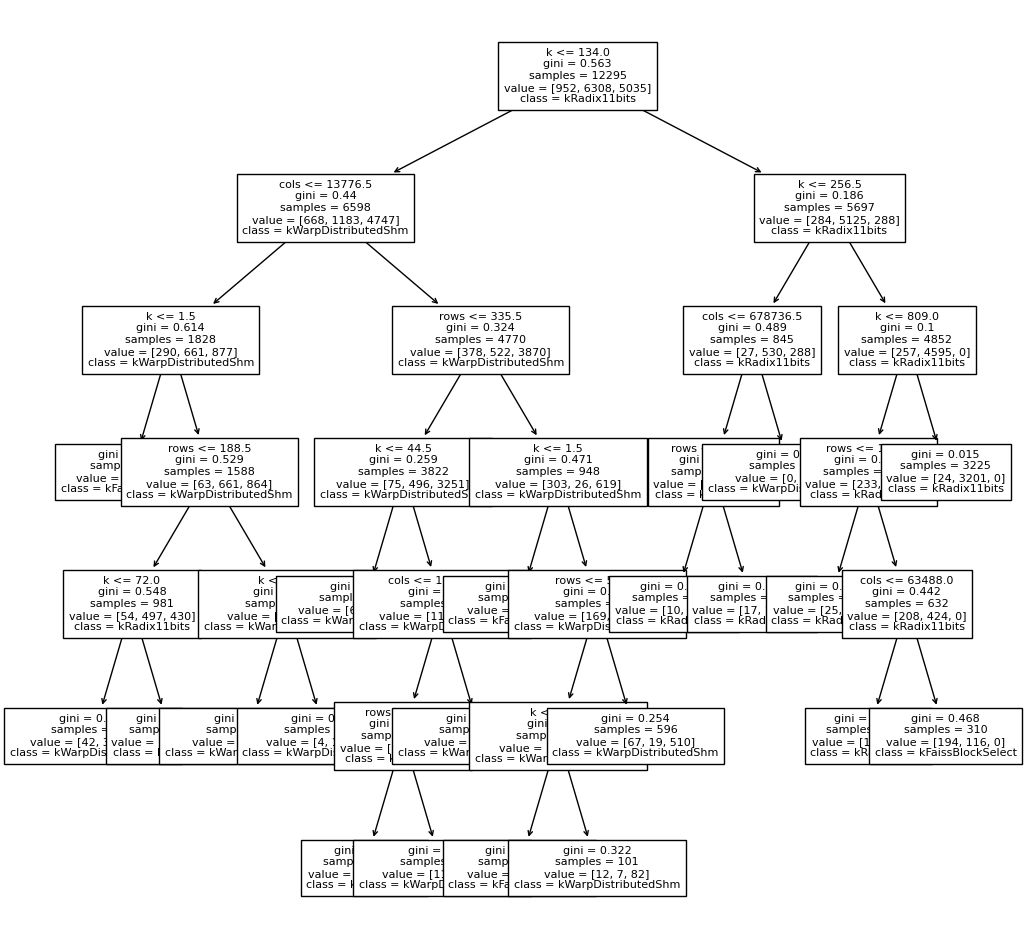

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
viz = sklearn.tree.plot_tree(model, fontsize=8, label='all', class_names=model.classes_, feature_names=["k", "rows", "cols", "use_memory_pool"], impurity=True)

In [9]:
def convert_model_to_code(model):
    classes = model.classes_
    tree = model.tree_
    feature_names = ["k", "rows", "cols", "use_memory_pool"]
    
    def _get_label(nodeid):
        """ returns the most frequent class name for the node """
        return classes[np.argsort(tree.value[nodeid, 0])[-1]]
    
    def _is_leaf_node(nodeid):
        """ returns whether or not the node is a leaf node in the tree"""
        # negative values here indicate we're a leaf
        if tree.feature[nodeid] < 0:
            return True
        
        # some nodes have both branches with the same label, combine those
        left, right = tree.children_left[nodeid], tree.children_right[nodeid]    
        if (_is_leaf_node(left) and 
            _is_leaf_node(right) and 
            _get_label(left) == _get_label(right)):
            return True
    
        return False
    
    code = []
    def _convert_node(nodeid, indent):
        if _is_leaf_node(nodeid):
            # we're a leaf node, just output the label of the most frequent algorithm
            class_name = _get_label(nodeid)
            code.append(" " * indent + f"return Algo::{class_name};")
        else:             
            feature = feature_names[tree.feature[nodeid]]
            threshold = int(np.floor(tree.threshold[nodeid]))
            code.append(" " * indent + f"if ({feature} > {threshold}) " + "{")
            _convert_node(tree.children_right[nodeid], indent + 2)
            code.append(" " * indent + "} else {")
            _convert_node(tree.children_left[nodeid], indent + 2)
            code.append(" " * indent + "}")
    
    code.append("inline Algo choose_select_k_algorithm(size_t rows, size_t cols, int k)")
    code.append("{")
    _convert_node(0, indent=2)
    code.append("}")
    return "\n".join(code)

code = convert_model_to_code(model)
print(code)

inline Algo choose_select_k_algorithm(size_t rows, size_t cols, int k)
{
  if (k > 134) {
    if (k > 256) {
      if (k > 809) {
        return Algo::kRadix11bits;
      } else {
        if (rows > 124) {
          if (cols > 63488) {
            return Algo::kFaissBlockSelect;
          } else {
            return Algo::kRadix11bits;
          }
        } else {
          return Algo::kRadix11bits;
        }
      }
    } else {
      if (cols > 678736) {
        return Algo::kWarpDistributedShm;
      } else {
        return Algo::kRadix11bits;
      }
    }
  } else {
    if (cols > 13776) {
      if (rows > 335) {
        if (k > 1) {
          if (rows > 546) {
            return Algo::kWarpDistributedShm;
          } else {
            if (k > 17) {
              return Algo::kWarpDistributedShm;
            } else {
              return Algo::kFaissBlockSelect;
            }
          }
        } else {
          return Algo::kFaissBlockSelect;
        }
      } else {
        

In [10]:
# also update the source code in raft/matrix/detail/select_k.cuh
import pathlib
select_k_path = pathlib.Path.cwd() / ".." / ".." / ".." / "include" / "raft" / "matrix" / "detail" / "select_k-inl.cuh"
source_lines = open(select_k_path.resolve()).read().split("\n")

# figure out the location of the code snippet in the file, and splice it in
code_lines = code.split("\n")
first_line = source_lines.index(code_lines[0])
last_line =  source_lines.index(code_lines[-1], first_line)
new_source = source_lines[:first_line] + code_lines + source_lines[last_line+1:]

open(select_k_path.resolve(), "w").write("\n".join(new_source))

6750